In [1]:
%matplotlib inline
from __future__ import division
from scipy.integrate import odeint
from scipy.optimize import minimize,root,fixed_point
from copy import deepcopy as dc
from math import e
from numpy import exp,pi,sqrt,log
import time
import numpy as np
import pylab as pl
pl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [20]:
import pickle

### 1 生成度分布序列

$d$表示平均度，$x$为度分布函数参数，$c$为标准化常数，$k\_list$为度列表。Gaussian distribution: $p(k)=c\frac{e^\frac{-(k-<k>)^2}{2\sigma^2}}{\sigma\sqrt{2\pi}}$,Lognormal distribution: $p(k)=c\frac{e^\frac{-(log(k)-<k>)^2}{2\sigma^2}}{\sigma\sqrt{2\pi}}$,Exponential distribution: $p(k)=c\frac{e^{-k\lambda}}{\lambda}$,Power law distribution: $p(k)=ck^{-\tau}$


In [64]:
class Gener_PK:
    k_list = np.arange(1,20)
    c = 2
    def __init__(self,d=6,g='power'):
        self.d = d
        self.g = g
        
    def gauss(self,x):
        pk_list = self.c*e**(-(self.k_list-x[0])**2/(2*x[1]**2))/(x[1]*sqrt(2*pi))   
        return np.sum(pk_list)-1,np.dot(pk_list,self.k_list)-self.d

    def logno(self,x):
        pk_list = self.c*e**(-(log(self.k_list)-x[0])**2/(2*x[1]**2))/(self.k_list*x[1]*sqrt(2*pi))
        return np.sum(pk_list)-1,np.dot(pk_list,self.k_list)-self.d

    def expon(self,x):
        pk_list = x[1]*e**(-self.k_list*x[0])
        return np.sum(pk_list)-1,np.dot(pk_list,self.k_list)-self.d

    def power(self,x):
        pk_list = x[1]*self.k_list**(-x[0])
        return np.sum(pk_list)-1,np.dot(pk_list,self.k_list)-self.d
    
    def get_pk(self):
        if self.g == 'gauss':
            sol = root(self.gauss,[6,1],args=(),method='lm')
            p_k = self.c*e**(-(self.k_list-sol.x[0])**2/(2*sol.x[1]**2))/(sol.x[1]*sqrt(2*pi))
        elif self.g == 'logno':
            sol = root(self.logno,[5,2],args=(),method='lm')
            p_k = self.c*e**(-(log(self.k_list)-sol.x[0])**2/(2*sol.x[1]**2))/(self.k_list*sol.x[1]*sqrt(2*pi))
        elif self.g == 'expon':
            sol = root(self.expon,[0.5,1.1],args=(),method='lm')
            p_k = sol.x[1]*e**(-self.k_list*sol.x[0])       
        else:
            sol = root(self.power,[1,1],args=(),method='lm')
            p_k = sol.x[1]*self.k_list**(-sol.x[0]) 
            
        return p_k

### 2 定义扩散微分方程组

#### F为扩散率的起始点，T为取样的时间，P_k为度分布列表，K_list为度列表，p和q分别为创新系数和模仿系数，m为潜在顾客数量  
首先定义$\frac{dF_{k}(t)}{dt}$，然后利用scipy.integrate.odeint生成$F_{k}(t)$的连续时间扩散序列

In [3]:
class Network_Diffuse:
    k_list = np.arange(1,100)
    def __init__(self,S,d=6,g='power'):
        self.d = d
        self.g = g
        self.S = np.array(S)
        self.len_s = len(self.S)
        self.T = np.arange(self.len_s)
        self.F = np.zeros_like(self.k_list)
    
    def evolve(self,F,t,p,q):
        theta = np.sum(F*self.p_k*self.k_list)/np.dot(self.p_k,self.k_list)
        return (1-F)*(p+q*self.k_list*theta)

    def gener_simulation(self,params):
        self.d = params[0]
        get_pk = Gener_PK(self.d)
        get_pk.g = self.g
        self.p_k = get_pk.get_pk()
        
        p,q,m = params[1:]
        t = self.T
        track = m*self.p_k*odeint(self.evolve,self.F,t,args=(p,q))
        accum_diff = np.sum(track,axis=1)
        insta_diff = np.zeros_like(self.T)
        for i in range(1,self.len_s):
            insta_diff[i] = accum_diff[i] - accum_diff[i-1]   
        return insta_diff

    def residuals(self,params):#残差平方和
        return np.sum(np.square(self.S - self.gener_simulation(params)))

    def mse(self,params):#均方误差
        simul_S = self.gener_simulation(params)
        return np.mean(np.square(simul_S - self.S))

    def cal_R_sigma(self,params):
        a = self.gener_simulation(params)
        sse = np.sum(np.square(self.S-a))
        ave_y = np.mean(self.S)
        ssl = np.sum(np.square(self.S-ave_y))
        R_2 = (ssl-sse)/ssl
        return R_2

In [56]:
class Random_Grid_Search:
    t_n = 500 #抽样量
    c_n = 50 #保留参数量
    threshold = 1e-4 #循环停止阈值
    end_steps = 150
    orig_points = [] #初始化边界点
    k_list = np.arange(1,20)
    
    def __init__(self,s,d=6,g='power'): #初始化实例参数
        self.s,self.s_len = np.array(s),len(s)
        self.d,self.g = d,g
        self.T = np.arange(self.s_len+1) #包括0时刻扩散量
        self.F = np.zeros_like(self.k_list)
        get_pk = Gener_PK(self.d)
        get_pk.g = self.g
        self.p_k = get_pk.get_pk() 
        self.para_range = [[1e-6,0.1],[1e-3/d,1/d],[sum(s),5*sum(s)]]  #参数范围
        self.p_range = [[1e-6,0.1],[1e-3/d,1/d],[sum(s),5*sum(s)]]  #用于产生边界节点的参数范围 
                        
    def gener_orig(self): #递归产生边界点
        if len(self.p_range) == 0:
            return
        else:  
            pa = self.p_range[-1]
            if self.orig_points == []:
                self.orig_points = [[pa[0]],[pa[1]]]  #初始化,排除orig_points为空的情形
            else:
                self.orig_points = [[pa[0]]+x for x in self.orig_points]+[[pa[1]]+x for x in self.orig_points]  #二分裂
            self.p_range.pop()
            return self.gener_orig()
    
    def sample(self,c_range): #抽样参数点
        p_list = []
        for pa in c_range:
            if isinstance(pa[0],float):
                x = (pa[1]-pa[0])*np.random.random(self.t_n) + pa[0]
            else:
                x = np.random.randint(low=pa[0],high=pa[1]+1,size=self.t_n)
            p_list.append(x)

        p_list = np.array(p_list).T
        return p_list.tolist()
    
    def evolve(self,F,t,p,q):
        theta = np.sum(F*self.p_k*self.k_list)/self.d
        return (1-F)*(p+q*self.k_list*theta)

    def f(self,params):
        p,q,m = params
        t = self.T
        track = m*self.p_k*odeint(self.evolve,self.F,t,args=(p,q))
        accum_diff = np.sum(track,axis=1)
        insta_diff = np.zeros_like(self.s)
        for i in range(self.s_len):
            insta_diff[i] = accum_diff[i+1] - accum_diff[i]   
        return insta_diff
    
    def r2(self,params):
        f_act = self.f(params)
        tse = np.sum(np.square(self.s-f_act))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s-mean_y))
        R_2 = (ssl-tse)/ssl
        return R_2

    def mse(self,params):  #定义适应度函数（mse）
        a = self.f(params)
        sse = np.sum(np.square(self.s-a))
        return np.sqrt(sse)/self.s_len #均方误
    
    def optima_search(self):
        self.gener_orig()
        c_range = dc(self.para_range)
        samp = self.sample(c_range)
        solution = sorted([self.mse(x)]+x for x in samp+self.orig_points)[:self.c_n]
        u = 1
        while 1:
            params_min = np.min(np.array(solution),0) #最小值
            params_max = np.max(np.array(solution),0) #最大值
            c_range = [[params_min[j+1],params_max[j+1]] for j in range(len(c_range))] #重新定界
            samp = self.sample(c_range)
            solution = sorted([[self.mse(x)]+x for x in samp]+solution)[:self.c_n]
            r = sorted([x[0] for x in solution])
            v = (r[-1]-r[0])/r[0]
            if v < self.threshold:        
                break
            if u > self.end_steps:
                print 'Searching ends in %s runs'%self.end_steps
                break
            u+=1
        return solution[0]  #sse,p,q,m

In [5]:
data_set = {'room air conditioners':(np.arange(1949,1962),[96,195,238,380,1045,1230,1267,1828,1586,1673,1800,1580,1500]),
                        'color televisions':(np.arange(1963,1971),[747,1480,2646,5118,5777,5982,5962,4631]),
                        'clothers dryers':(np.arange(1949,1962),[106,319,492,635,737,890,1397,1523,1294,1240,1425,1260,1236]),
                        'ultrasound':(np.arange(1965,1979),[5,3,2,5,7,12,6,16,16,28,28,21,13,6]),
                        'mammography':(np.arange(1965,1979),[2,2,2,3,4,9,7,16,23,24,15,6,5,1]),
                        'foreign language':(np.arange(1952,1964),[1.25,0.77,0.86,0.48,1.34,3.56,3.36,6.24,5.95,6.24,4.89,0.25]),
                        'accelerated program':(np.arange(1952,1964),[0.67,0.48,2.11,0.29,2.59,2.21,16.80,11.04,14.40,6.43,6.15,1.15])}
china_set = {'color tv':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
                         'mobile phone':(np.arange(1997,2013),[1.7,1.6,3.84,12.36,14.5,28.89,27.18,21.33,25.6,15.88,12.3,6.84,9.02,7.82,16.39,7.39]),
                         }

In [6]:
tx = 'clothers dryers'
S = data_set[tx][1]

In [65]:
fit_dict = {}

In [66]:
for g in ['power','logno','gauss','expon']:
    print '============================%s============================='%g
    r2_list = []
    mean_std = []
    params_list = []
    for d in range(3,13):
        print '*****%s******'%d
        t1 = time.clock()
        rgs = Random_Grid_Search(S,d,g)
        est = rgs.optima_search()
        params = est[1:]
        r2 = rgs.r2(params)
        std = np.std(rgs.p_k)
        
        r2_list.append(r2)
        mean_std.append([d,std])
        params_list.append(params)
        
        print '    time elasped:',time.clock()-t1,'s'
        print '    r2:%.4f,    p:%.4f,   q:%.4f,    m:%d'%tuple([r2]+params)
        print '    mean:%s    std:%s'%(d,std)
        
    fit_dict[g]={'params':params_list,'r2':r2_list,'mean_std':mean_std}

============================power=============================
*****3******
Searching ends in 150 runs
    time elasped: 103.358356298 s
    r2:0.9383,    p:0.0087,   q:0.0716,    m:24319
    mean:3    std:0.115056150474
*****4******
Searching ends in 150 runs
    time elasped: 99.8117136489 s
    r2:0.9324,    p:0.0094,   q:0.0540,    m:24093
    mean:4    std:0.0896749147875
*****5******
Searching ends in 150 runs
    time elasped: 87.4702953501 s
    r2:0.9280,    p:0.0100,   q:0.0450,    m:23316
    mean:5    std:0.0689611077862
*****6******
Searching ends in 150 runs
    time elasped: 86.105299276 s
    r2:0.9251,    p:0.0105,   q:0.0392,    m:22287
    mean:6    std:0.0513781437481
*****7******
Searching ends in 150 runs
    time elasped: 88.0618440837 s
    r2:0.9233,    p:0.0110,   q:0.0351,    m:21404
    mean:7    std:0.0361295216702
*****8******
Searching ends in 150 runs
    time elasped: 76.1750823522 s
    r2:0.9221,    p:0.0114,   q:0.0323,    m:20492
    mean:8    std:0

In [67]:
to_save = pickle.dumps(fit_dict)
f = open('estimation for clothers dryers (3-12)-20-c=2.txt','w')
f.write(to_save)
f.close()

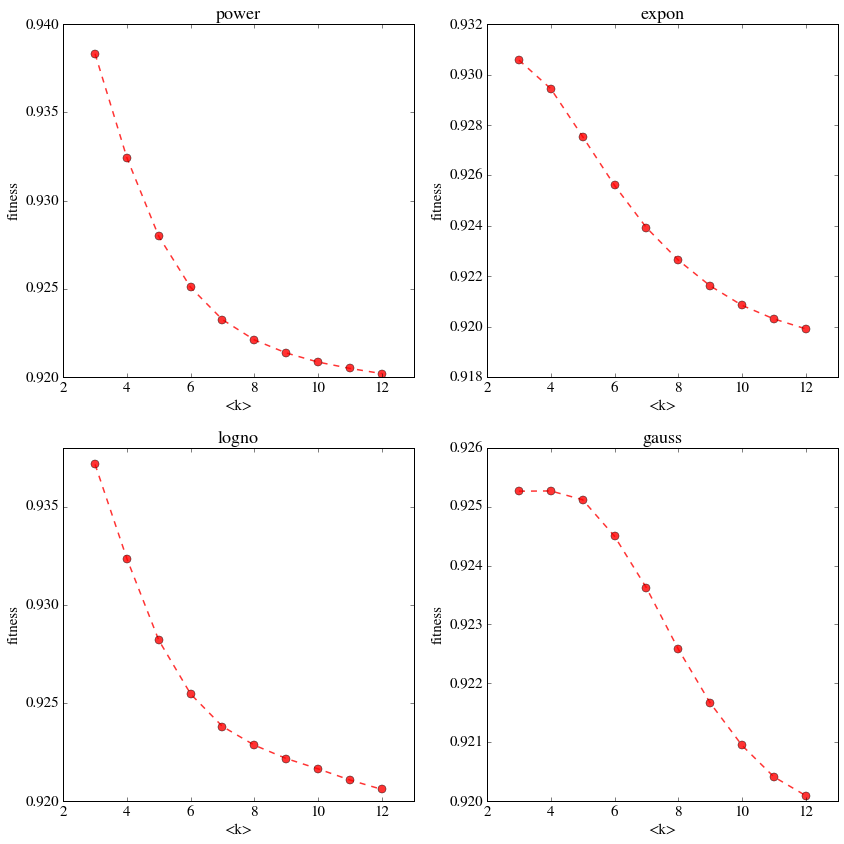

In [70]:
fig = pl.figure(figsize=(12,12))
mean_k = range(3,13)

i = 1
for m in ['power','expon','logno','gauss']:
    ax = fig.add_subplot(2,2,i)
    r2_list = fit_dict[m]['r2']
    std_list = [x[1] for x in fit_dict[m]['mean_std']]
    ax.plot(mean_k,r2_list,'ro--',lw=1.5,ms=8,alpha=0.8)
    
    ax.set_xlim([2,13])
    ax.set_xlabel('<k>')
    ax.set_ylabel('fitness')
    ax.set_title(m)
    i = i+1
    
pl.tight_layout()
    

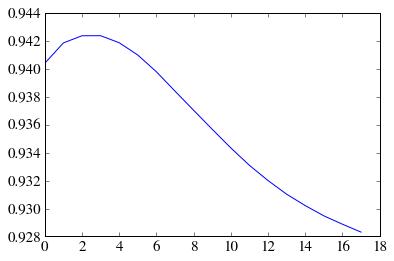

In [61]:
pl.plot(r2_list) #logno

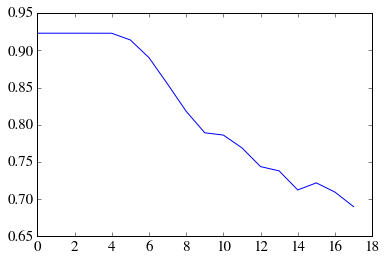

In [59]:
pl.plot(r2_list) #expon

In [54]:
r_list = [0.9397,0.9437,0.9447,0.9438,0.9400,0.9378,0.9358,0.9339,0.9322,0.9307,0.9294,0.9283,0.9273,0.9264,0.9257,0.9251,0.9245]

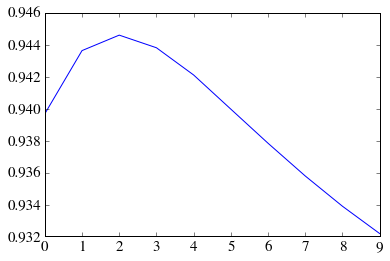

In [11]:
pl.plot(np.arange(3,13),power_r2,'ko-',lw=1.5,ms=1.3) #power
pl.xlabel('d')
pl.ylabel('R^2')


In [50]:
x = rgs.f(params)
year = data_set[tx][0]

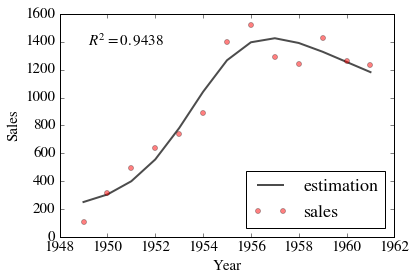

In [51]:
pl.text(min(year)+0.2,max(S)*0.9,'$R^2=%.4f$'%r2)
pl.plot(year,x,'k-',lw=2,alpha=0.7,label='estimation')
pl.plot(year,S,'ro',ms=5,alpha=0.5,label='sales')
pl.xlabel('Year')
pl.ylabel('Sales')
pl.legend(loc=4)

#### (4)例子

In [ ]:
T = np.arange(60)
F = np.zeros_like(k_list)
ini_params = [6,0.001,0.02,100000]

insta_1 = gener_simulation(ini_params,'power',F,T,k_list)
insta_2 = gener_simulation(ini_params,'lognormal',F,T,k_list)
insta_3 = gener_simulation(ini_params,'exponential',F,T,k_list)
insta_4 = gener_simulation(ini_params,'gaussian',F,T,k_list)

pl.figure(figsize=(12,6))
pl.xlabel('time step')
pl.ylabel('number of adoptors')
pl.plot(insta_1,'ko-',label='power')
pl.plot(insta_2,'k*-',label='lognormal')
pl.plot(insta_3,'ks-',label='exponential')
pl.plot(insta_4,'kp-',label='gaussian')
pl.legend(loc='best')
pl.grid()

### 实证扩散数据拟合

网络度分布设置：幂律分布，指数分布，泊松分布和二项分布

In [ ]:
K_list = np.arange(1,100,1)
mean_degre = 3
mu,sigma = 1.37,1
beta_range = np.arange(0,2.1,0.1)

pk_pow = 0.6237*k_list**(-2.037)
pk_pow[0] = 1 - np.sum(pk_pow[1:])

pk_exp = 0.5*e**(-0.405*k_list)
pk_exp[0] = 1 - np.sum(pk_exp[1:])

pk_pos = 1.0633*stats.poisson.pmf(k_list,2.8214)
pk_pos[0] = 1 - np.sum(pk_pos[1:])

pk_bio = np.array([stats.binom.pmf(i,len(k_list),0.02020202) for i in range(len(k_list))])
pk_bio[0] = 1 - np.sum(pk_bio[1:])

数据集合

In [44]:
data_set = {'room air conditioners':(np.arange(1949,1962),[96,195,238,380,1045,1230,1267,1828,1586,1673,1800,1580,1500]),
            'color televisions':(np.arange(1963,1971),[747,1480,2646,5118,5777,5982,5962,4631]),
            'clothers dryers':(np.arange(1949,1962),[106,319,492,635,737,890,1397,1523,1294,1240,1425,1260,1236]),
            'ultrasound':(np.arange(1965,1979),[5,3,2,5,7,12,6,16,16,28,28,21,13,6]),
            'mammography':(np.arange(1965,1979),[2,2,2,3,4,9,7,16,23,24,15,6,5,1]),
            'foreign language':(np.arange(1952,1964),[1.25,0.77,0.86,0.48,1.34,3.56,3.36,6.24,5.95,6.24,4.89,0.25]),
            'accelerated program':(np.arange(1952,1964),[0.67,0.48,2.11,0.29,2.59,2.21,16.80,11.04,14.40,6.43,6.15,1.15])}
china_set = {'color tv':(np.arange(1997,2013),[2.6,1.2,2.11,3.79,3.6,7.33,7.18,5.29,8.42,5.68,6.57,5.49,6.48,5.42,10.72,5.15]),
             'mobile phone':(np.arange(1997,2013),[1.7,1.6,3.84,12.36,14.5,28.89,27.18,21.33,25.6,15.88,12.3,6.84,9.02,7.82,16.39,7.39]),
             }

In [45]:
S = data_set['room air conditioners'][1]

In [ ]:
year = data_set['room air conditioners'][0]
S = data_set['room air conditioners'][1]
T = np.arange(len(S))
F = np.zeros_like(k_list)

In [ ]:
g = 'exponential'
x0 = (5,0.005,0.05,3*sum(S))
t1 = time.clock()
res = minimize(mse,x0,args=(g,S,T,F,k_list),method='powell',options={'disp':True}) 
print '用时:',time.clock()-t1,'s'
print '参数估计值:','mean degree=',res.x[0],'p=',res.x[1],'q=',res.x[2],'m=',res.x[3]

In [ ]:
x = res.x
f_S = gener_simulation(x,g,F,T,k_list)

In [ ]:
r2,sigma = cal_R_sigma(x,g,S,F,T,k_list)

In [ ]:
fig = pl.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(year,S,'o',c='grey',ms=7,label='Actual')
ax.plot(year,f_S,'k-',label='Fitted')
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Sales',fontsize=15)
ax.set_xlim(year[0],year[-1])
ax.set_title('The estimation result')
ax.legend(loc='best',fontsize=15)

### 微分方程组积分示例

#### 微分方程组的积分结果和选取的时间点无关，这说明了方法的正确性

In [ ]:
T1 = np.linspace(0,20,20)
T2 = np.linspace(0,20,100)
T3 = np.linspace(0,20,1000)
T4 = np.linspace(0,20,10000)
T_cont = [T1,T2,T3,T4]
p,q,m=0.01,0.2,10000
A_cont,I_cont = [],[]

for i in range(4):
    accum_diff = np.sum(m*P_k*odeint(evolve,F,T_cont[i],args=(P_k,K_list,p,q)),axis=1)
    insta_diff = np.zeros_like(accum_diff)
    for i in range(1,len(accum_diff)):
        insta_diff[i] = accum_diff[i]-accum_diff[i-1]
        
    I_cont.append(insta_diff)
    A_cont.append(accum_diff)

In [ ]:
A_cont[0][1],np.sum(A_cont[1][1]),np.sum(A_cont[2][1])

In [ ]:
for i in range(4):
    pl.plot(T_cont[i],A_cont[i],'%s'%C_cont[i])

In [ ]:
%matplotlib inline
C_cont = ['ko-','bo-','go-','ro-']
fig = pl.figure(figsize=(8,8))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(T_cont[i],I_cont[i],'%s'%C_cont[i])
    
pl.tight_layout()